### Загрузка данных

In [1]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time
import ssl
import urllib.request

from matplotlib import pyplot as plt
import numpy as np

In [3]:
# Преобразование данных
transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
# Отключение проверки SSL-сертификата для загрузки CIFAR-10
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# Загрузка датасета CIFAR-10 для демонстрации
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Создание загрузчика данных для демонстрации
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Количество данных
print(len(train_dataset), len(test_dataset))

50000 10000


In [7]:
# Вспомогательная функция для отрисовки изображений
def image_show(image_data):
    plt.figure(figsize = (3, 3))
    plt.imshow(np.transpose(image_data.numpy(), (1, 2, 0)))
    
    plt.show()

Примеры изображений и соответствующих меток:
Изображение № 1
Метка класса: Самолет


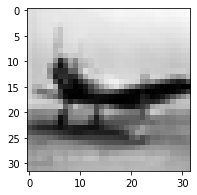


Изображение № 2
Метка класса: Олень


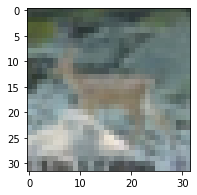


Изображение № 3
Метка класса: Лошадь


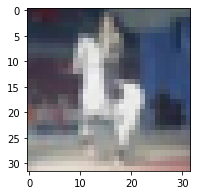


Изображение № 4
Метка класса: Корабль


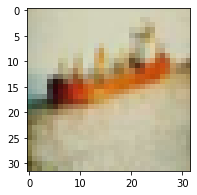


Изображение № 5
Метка класса: Грузовик


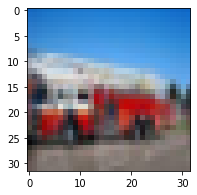

In [8]:
# Демонстрация изображений и меток классов
class_names = ['Самолет', 'Автомобиль', 'Птица', 'Кот', 'Олень',
               'Собака', 'Лягушка', 'Лошадь', 'Корабль', 'Грузовик']

print("Примеры изображений и соответствующих меток:")
for images, labels in train_loader:
    for i in range(5):
        print("Изображение №", i + 1)
        print("Метка класса:", class_names[labels[i].item()])
        image_show(images[i])
        print()
    break

### Построение архитектуры сверточной сети

In [9]:
# Переопределение загрузчика данных CIFAR-10 для обучения
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [10]:
# Определение сверточной модели
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

# Инициализация модели
model = ConvNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### Обучение модели

In [13]:
start_time = time.time()
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    epoch_time = time.time()

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / total_predictions
    epoch_loss = running_loss / len(train_loader)

    print("Эпоха", epoch + 1)
    print("Ошибка классификации:", epoch_loss)
    print("Точность:", accuracy)
    print(f"Время обучения эпохи: {time.time() - epoch_time} сек")
    print()

print(f"Общее время обучения: {time.time() - start_time} сек")

Эпоха 1
Ошибка классификации: 2.0100592025710493
Точность: 0.25426
Время обучения эпохи: 53.38013243675232 сек

Эпоха 2
Ошибка классификации: 1.449109239346536
Точность: 0.47524
Время обучения эпохи: 52.07155776023865 сек

Эпоха 3
Ошибка классификации: 1.2052674485594415
Точность: 0.56984
Время обучения эпохи: 50.805521965026855 сек

Эпоха 4
Ошибка классификации: 1.0529242699865795
Точность: 0.6276
Время обучения эпохи: 49.45999765396118 сек

Эпоха 5
Ошибка классификации: 0.9252951284656135
Точность: 0.67442
Время обучения эпохи: 49.179001808166504 сек

Эпоха 6
Ошибка классификации: 0.8303698106571231
Точность: 0.70828
Время обучения эпохи: 49.50000071525574 сек

Эпоха 7
Ошибка классификации: 0.7491598367081274
Точность: 0.7369
Время обучения эпохи: 49.712997913360596 сек

Эпоха 8
Ошибка классификации: 0.6703069041223477
Точность: 0.76438
Время обучения эпохи: 56.05383586883545 сек

Эпоха 9
Ошибка классификации: 0.5888983984203899
Точность: 0.7941
Время обучения эпохи: 55.8468980789184

### Тестирование модели

In [21]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Точность на тестовом наборе данных:", correct / total)

Точность на тестовом наборе данных: 0.7686
